In [18]:
import pandas as pd
import duckdb as db
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Connected to database: ../../database/clinisys_all.duckdb
Database file exists: True

=== Available Schemas ===
          schema_name
0              bronze
1                gold
2                main
3              silver
4  information_schema
5                main
6          pg_catalog
7                main

=== Tables in Silver Schema (16 tables) ===
                           table_name  table_type
0         view_congelamentos_embrioes  BASE TABLE
1           view_congelamentos_ovulos  BASE TABLE
2      view_descongelamentos_embrioes  BASE TABLE
3        view_descongelamentos_ovulos  BASE TABLE
4            view_embrioes_congelados  BASE TABLE
5   view_extrato_atendimentos_central  BASE TABLE
6                   view_medicamentos  BASE TABLE
7       view_medicamentos_prescricoes  BASE TABLE
8                        view_medicos  BASE TABLE
9               view_micromanipulacao  BASE TABLE
10      view_micromanipulacao_oocitos  BASE TABLE
11                    view_orcamentos  BASE T
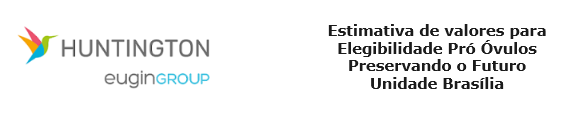
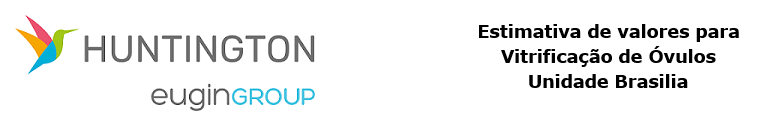
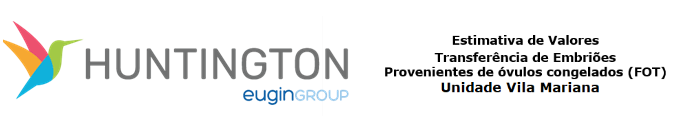
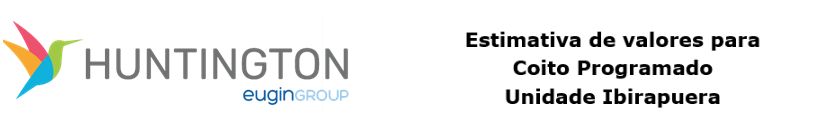
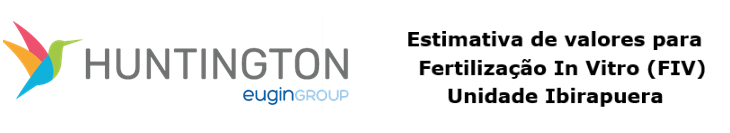

In [19]:
# Connect to the clinisys_all database
path_to_db = '../../database/clinisys_all.duckdb'
conn = db.connect(path_to_db, read_only=True)

print(f"Connected to database: {path_to_db}")
print(f"Database file exists: {os.path.exists(path_to_db)}")

# List all schemas
schemas = conn.execute("SELECT schema_name FROM information_schema.schemata").fetchdf()
print("\n=== Available Schemas ===")
print(schemas)

# List all tables in silver schema
silver_tables = conn.execute("""
    SELECT table_name, table_type 
    FROM information_schema.tables 
    WHERE table_schema = 'silver'
    ORDER BY table_name
""").fetchdf()

print(f"\n=== Tables in Silver Schema ({len(silver_tables)} tables) ===")
print(silver_tables)

# Explore each table in silver schema
print("\n" + "="*80)
print("EXPLORING SILVER SCHEMA TABLES")
print("="*80)

for idx, row in silver_tables.iterrows():
    table_name = row['table_name']
    table_type = row['table_type']
    
    print(f"\n{'='*60}")
    print(f"TABLE: {table_name} (Type: {table_type})")
    print(f"{'='*60}")
    
    try:
        # Get table schema
        schema_info = conn.execute(f"""
            SELECT column_name, data_type, is_nullable
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = '{table_name}'
            ORDER BY ordinal_position
        """).fetchdf()
        
        print(f"\nSchema ({len(schema_info)} columns):")
        # print(schema_info.to_string(index=False))
        
        # Get row count
        count_result = conn.execute(f"SELECT COUNT(*) as row_count FROM silver.{table_name}").fetchdf()
        row_count = count_result['row_count'].iloc[0]
        print(f"\nTotal rows: {row_count:,}")
        
        # Get sample data (first 10 rows)
        if row_count > 0:
            sample_data = conn.execute(f"SELECT * FROM silver.{table_name} LIMIT 10").fetchdf()
            print(f"\nSample data (first 10 rows):")
            print(sample_data.to_string(index=False))
            
            # Show data types and null counts
            print(f"\nData info:")
            print(f"Shape: {sample_data.shape}")
            print(f"Memory usage: {sample_data.memory_usage(deep=True).sum() / 1024:.2f} KB")
            
            # Show null counts for each column
            null_counts = sample_data.isnull().sum()
            if null_counts.sum() > 0:
                print(f"\nNull counts in sample:")
                for col, null_count in null_counts.items():
                    if null_count > 0:
                        print(f"  {col}: {null_count}")
        else:
            print("\nTable is empty - no sample data to show")
            
    except Exception as e:
        print(f"Error exploring table {table_name}: {str(e)}")
    
    print(f"\n{'-'*60}")

# Close connection
conn.close()
print(f"\n{'='*80}")
print("EXPLORATION COMPLETE")
print(f"{'='*80}")

In [20]:
#!/usr/bin/env python3
"""
Extract Prontuario Data - Modular Functions
Extract data for a specific prontuario from finops tables with individual functions for each table.
"""

import pandas as pd
import duckdb as db
import os

def get_database_connection():
    """
    Create and return a connection to the clinisys_all database
    
    Returns:
        duckdb.DuckDBPyConnection: Database connection
    """
    path_to_db = '../../database/clinisys_all.duckdb'
    conn = db.connect(path_to_db, read_only=True)
    
    print(f"Connected to database: {path_to_db}")
    print(f"Database file exists: {os.path.exists(path_to_db)}")
    
    return conn

def extract_orcamentos_data(conn, target_prontuario):
    """
    Extract orcamentos data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing orcamentos data
    """
    print(f"\n2. EXTRACTING VIEW_ORCAMENTOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_orc = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_orcamentos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_orcamentos columns: {list(schema_orc['column_name'])}")
        
        # Extract data
        orcamentos_df = conn.execute(f"""
            SELECT * FROM silver.view_orcamentos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(orcamentos_df)} records in view_orcamentos")
        if len(orcamentos_df) > 0:
            print("Sample data:")
            print(orcamentos_df.head())
            print(f"Columns: {list(orcamentos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting orcamentos data: {str(e)}")
        orcamentos_df = pd.DataFrame()
    
    return orcamentos_df

def extract_extrato_atendimento_central_data(conn, target_prontuario):
    """
    Extract extrato_atendimento_central data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing extrato_atendimento_central data
    """
    print(f"\n3. EXTRACTING VIEW_EXTRATO_ATENDIMENTO_CENTRAL DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_eac = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_extrato_atendimentos_central'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_extrato_atendimento_central columns: {list(schema_eac['column_name'])}")
        
        # Extract data
        extrato_atendimento_central_df = conn.execute(f"""
            SELECT * FROM silver.view_extrato_atendimentos_central 
            WHERE prontuario = {target_prontuario}
            ORDER BY data DESC, inicio DESC
        """).fetchdf()
        
        print(f"Found {len(extrato_atendimento_central_df)} records in view_extrato_atendimento_central")
        if len(extrato_atendimento_central_df) > 0:
            print("Sample data:")
            print(extrato_atendimento_central_df.head())
            print(f"Columns: {list(extrato_atendimento_central_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting extrato_atendimento_central data: {str(e)}")
        extrato_atendimento_central_df = pd.DataFrame()
    
    return extrato_atendimento_central_df

def extract_tratamentos_data(conn, target_prontuario):
    """
    Extract tratamentos data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing tratamentos data
    """
    print(f"\n4. EXTRACTING VIEW_TRATAMENTOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_trat = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_tratamentos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_tratamentos columns: {list(schema_trat['column_name'])}")
        
        # Extract data
        tratamentos_df = conn.execute(f"""
            SELECT * FROM silver.view_tratamentos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(tratamentos_df)} records in view_tratamentos")
        if len(tratamentos_df) > 0:
            print("Sample data:")
            print(tratamentos_df.head())
            print(f"Columns: {list(tratamentos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting tratamentos data: {str(e)}")
        tratamentos_df = pd.DataFrame()
    
    return tratamentos_df

def extract_congelamentos_embrioes_data(conn, target_prontuario):
    """
    Extract congelamentos_embrioes data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing congelamentos_embrioes data
    """
    print(f"\n5. EXTRACTING VIEW_CONGELAMENTOS_EMBRIOES DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_ce = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_congelamentos_embrioes'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_congelamentos_embrioes columns: {list(schema_ce['column_name'])}")
        
        # Extract data
        congelamentos_embrioes_df = conn.execute(f"""
            SELECT * FROM silver.view_congelamentos_embrioes 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(congelamentos_embrioes_df)} records in view_congelamentos_embrioes")
        if len(congelamentos_embrioes_df) > 0:
            print("Sample data:")
            print(congelamentos_embrioes_df.head())
            print(f"Columns: {list(congelamentos_embrioes_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting congelamentos_embrioes data: {str(e)}")
        congelamentos_embrioes_df = pd.DataFrame()
    
    return congelamentos_embrioes_df

def extract_congelamentos_ovulos_data(conn, target_prontuario):
    """
    Extract congelamentos_ovulos data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing congelamentos_ovulos data
    """
    print(f"\n6. EXTRACTING VIEW_CONGELAMENTOS_OVULOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_co = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_congelamentos_ovulos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_congelamentos_ovulos columns: {list(schema_co['column_name'])}")
        
        # Extract data
        congelamentos_ovulos_df = conn.execute(f"""
            SELECT * FROM silver.view_congelamentos_ovulos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(congelamentos_ovulos_df)} records in view_congelamentos_ovulos")
        if len(congelamentos_ovulos_df) > 0:
            print("Sample data:")
            print(congelamentos_ovulos_df.head())
            print(f"Columns: {list(congelamentos_ovulos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting congelamentos_ovulos data: {str(e)}")
        congelamentos_ovulos_df = pd.DataFrame()
    
    return congelamentos_ovulos_df

def extract_descongelamentos_embrioes_data(conn, target_prontuario):
    """
    Extract descongelamentos_embrioes data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing descongelamentos_embrioes data
    """
    print(f"\n7. EXTRACTING VIEW_DESCONGELAMENTOS_EMBRIOES DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_de = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_descongelamentos_embrioes'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_descongelamentos_embrioes columns: {list(schema_de['column_name'])}")
        
        # Extract data
        descongelamentos_embrioes_df = conn.execute(f"""
            SELECT * FROM silver.view_descongelamentos_embrioes 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(descongelamentos_embrioes_df)} records in view_descongelamentos_embrioes")
        if len(descongelamentos_embrioes_df) > 0:
            print("Sample data:")
            print(descongelamentos_embrioes_df.head())
            print(f"Columns: {list(descongelamentos_embrioes_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting descongelamentos_embrioes data: {str(e)}")
        descongelamentos_embrioes_df = pd.DataFrame()
    
    return descongelamentos_embrioes_df

def extract_descongelamentos_ovulos_data(conn, target_prontuario):
    """
    Extract descongelamentos_ovulos data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing descongelamentos_ovulos data
    """
    print(f"\n8. EXTRACTING VIEW_DESCONGELAMENTOS_OVULOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_do = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_descongelamentos_ovulos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_descongelamentos_ovulos columns: {list(schema_do['column_name'])}")
        
        # Extract data
        descongelamentos_ovulos_df = conn.execute(f"""
            SELECT * FROM silver.view_descongelamentos_ovulos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(descongelamentos_ovulos_df)} records in view_descongelamentos_ovulos")
        if len(descongelamentos_ovulos_df) > 0:
            print("Sample data:")
            print(descongelamentos_ovulos_df.head())
            print(f"Columns: {list(descongelamentos_ovulos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting descongelamentos_ovulos data: {str(e)}")
        descongelamentos_ovulos_df = pd.DataFrame()
    
    return descongelamentos_ovulos_df

def extract_embrioes_congelados_data(conn, target_prontuario):
    """
    Extract embrioes_congelados data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing embrioes_congelados data
    """
    print(f"\n9. EXTRACTING VIEW_EMBRIOES_CONGELADOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_ec = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_embrioes_congelados'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_embrioes_congelados columns: {list(schema_ec['column_name'])}")
        
        # Extract data
        embrioes_congelados_df = conn.execute(f"""
            SELECT * FROM silver.view_embrioes_congelados 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(embrioes_congelados_df)} records in view_embrioes_congelados")
        if len(embrioes_congelados_df) > 0:
            print("Sample data:")
            print(embrioes_congelados_df.head())
            print(f"Columns: {list(embrioes_congelados_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting embrioes_congelados data: {str(e)}")
        embrioes_congelados_df = pd.DataFrame()
    
    return embrioes_congelados_df

def extract_prontuario_data(target_prontuario=876950):
    """
    Extract all data for a specific prontuario from the finops tables:
    - view_orcamentos  
    - view_extrato_atendimento_central
    - view_tratamentos
    - view_congelamentos_embrioes
    - view_congelamentos_ovulos
    - view_descongelamentos_embrioes
    - view_descongelamentos_ovulos
    - view_embrioes_congelados
    
    Args:
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        tuple: Eight DataFrames containing the extracted data
    """
    
    print(f"\n{'='*80}")
    print(f"EXTRACTING DATA FOR PRONTUARIO: {target_prontuario}")
    print(f"{'='*80}")
    
    # Get database connection
    conn = get_database_connection()
    
    try:
        # Extract data from each table using individual functions
        orcamentos_df = extract_orcamentos_data(conn, target_prontuario)
        extrato_atendimento_central_df = extract_extrato_atendimento_central_data(conn, target_prontuario)
        tratamentos_df = extract_tratamentos_data(conn, target_prontuario)
        congelamentos_embrioes_df = extract_congelamentos_embrioes_data(conn, target_prontuario)
        congelamentos_ovulos_df = extract_congelamentos_ovulos_data(conn, target_prontuario)
        descongelamentos_embrioes_df = extract_descongelamentos_embrioes_data(conn, target_prontuario)
        descongelamentos_ovulos_df = extract_descongelamentos_ovulos_data(conn, target_prontuario)
        embrioes_congelados_df = extract_embrioes_congelados_data(conn, target_prontuario)
        
        # Summary
        print(f"\n{'='*80}")
        print(f"SUMMARY FOR PRONTUARIO {target_prontuario}")
        print(f"{'='*80}")
        print(f"view_orcamentos: {len(orcamentos_df)} records")
        print(f"view_extrato_atendimento_central: {len(extrato_atendimento_central_df)} records")
        print(f"view_tratamentos: {len(tratamentos_df)} records")
        print(f"view_congelamentos_embrioes: {len(congelamentos_embrioes_df)} records")
        print(f"view_congelamentos_ovulos: {len(congelamentos_ovulos_df)} records")
        print(f"view_descongelamentos_embrioes: {len(descongelamentos_embrioes_df)} records")
        print(f"view_descongelamentos_ovulos: {len(descongelamentos_ovulos_df)} records")
        print(f"view_embrioes_congelados: {len(embrioes_congelados_df)} records")
        
        print(f"\n{'='*80}")
        print("DATA EXTRACTION COMPLETE")
        print(f"{'='*80}")
        print("DataFrames available:")
        print("- orcamentos_df") 
        print("- extrato_atendimento_central_df")
        print("- tratamentos_df")
        print("- congelamentos_embrioes_df")
        print("- congelamentos_ovulos_df")
        print("- descongelamentos_embrioes_df")
        print("- descongelamentos_ovulos_df")
        print("- embrioes_congelados_df")
        
        return (orcamentos_df, extrato_atendimento_central_df, tratamentos_df, 
                congelamentos_embrioes_df, congelamentos_ovulos_df, 
                descongelamentos_embrioes_df, descongelamentos_ovulos_df, 
                embrioes_congelados_df)
        
    finally:
        # Close connection
        conn.close()

def find_in_diario_by_all_ids(prontuario: int) -> pd.DataFrame:
    """
    Find all records in diario_vendas by all ids in the patient_id list.
    
    Args:
        patient_id (int): The patient's id
        
    Returns:
        pd.DataFrame: DataFrame containing all diario_vendas records for the patient
    """
    CLINISYS_DB_PATH = '../../database/clinisys_all.duckdb'
    HUNTINGTON_DB_PATH = '../../database/huntington_data_lake.duckdb'
    
    try:
        # First, get all records from silver.view_pacientes where codigo=prontuario
        with db.connect(CLINISYS_DB_PATH, read_only=True) as con:
            query_pacientes = f"""
            SELECT *
            FROM silver.view_pacientes
            WHERE codigo = {prontuario}
            """
            
            df_pacientes = con.execute(query_pacientes).df()
            
            if df_pacientes.empty:
                print(f"No records found in silver.view_pacientes for prontuario {prontuario}")
                return []
            
            print(f"Found {len(df_pacientes)} records in silver.view_pacientes for prontuario {prontuario}")
            print("Patient information:")            
            prontuario_columns = [col for col in df_pacientes.columns if 'prontuario' in col.lower()]
            print(f"Found prontuario columns: {prontuario_columns}")
            
            all_prontuarios = []
            for column in prontuario_columns:
                value = df_pacientes[column].iloc[0]
                # Check if value is not NaN and not None and not 0
                if pd.notna(value) and value is not None and value != 0:
                    all_prontuarios.append(int(value))
            
            # Remove duplicates
            codigos = list(set(all_prontuarios))
            print(f"Valid prontuario codes (no NaNs): {codigos}")


            # Then, get all records from diario_vendas for these codigos
            with db.connect(HUNTINGTON_DB_PATH, read_only=True) as con:
                # Create the IN clause for the query
                codigos_str = ','.join(map(str, codigos))
                
                query_diario = f"""
                SELECT *
                FROM silver.diario_vendas
                WHERE "Cliente" IN ({codigos_str})
                ORDER BY "DT Emissao" DESC
                """
                
                df_diario = con.execute(query_diario).df()
                
                if df_diario.empty:
                    print(f"No records found in silver.diario_vendas for codigos {codigos}")
                    return df_diario
                
                print(f"Found {len(df_diario)} records in silver.diario_vendas for codigos {codigos}")
                return df_diario
            

    except Exception as e:
        print(f"Error retrieving diario_vendas data for prontuario {prontuario}: {e}")
        return pd.DataFrame()

if __name__ == "__main__":
    # Example usage
    (orcamentos_df, extrato_atendimento_central_df, tratamentos_df, 
     congelamentos_embrioes_df, congelamentos_ovulos_df, 
     descongelamentos_embrioes_df, descongelamentos_ovulos_df, 
     embrioes_congelados_df) = extract_prontuario_data(876950)
    
    # You can now work with the DataFrames
    print("\n DataFrames loaded successfully!")
    print(f"orcamentos_df shape: {orcamentos_df.shape}")
    print(f"extrato_atendimento_central_df shape: {extrato_atendimento_central_df.shape}")
    print(f"tratamentos_df shape: {tratamentos_df.shape}")
    print(f"congelamentos_embrioes_df shape: {congelamentos_embrioes_df.shape}")
    print(f"congelamentos_ovulos_df shape: {congelamentos_ovulos_df.shape}")
    print(f"descongelamentos_embrioes_df shape: {descongelamentos_embrioes_df.shape}")
    print(f"descongelamentos_ovulos_df shape: {descongelamentos_ovulos_df.shape}")
    print(f"embrioes_congelados_df shape: {embrioes_congelados_df.shape}")
    
    # Example of using the diario function
    diario_df = find_in_diario_by_all_ids(876950)
    print(f"diario_df shape: {diario_df.shape}") 


EXTRACTING DATA FOR PRONTUARIO: 876950
Connected to database: ../../database/clinisys_all.duckdb
Database file exists: True

2. EXTRACTING VIEW_ORCAMENTOS DATA
--------------------------------------------------
view_orcamentos columns: ['id', 'prontuario', 'paciente', 'clinica', 'tipo_cotacao', 'profissional', 'status', 'status_entrega', 'nome_contato', 'telefone_contato', 'email_contato', 'comentario_para_paciente', 'comentario_do_paciente', 'orcamento_texto', 'descricao', 'fornecedor', 'qtd_cotada', 'unidade', 'valor_unidade', 'total', 'data_entrega', 'centro_custos', 'valor_total', 'forma', 'parcelas', 'comentarios', 'forma_parcela', 'valor', 'data_pagamento', 'descricao_pagamento', 'data', 'responsavel', 'data_entrega_orcamento', 'data_ultima_modificacao', 'hash', 'extraction_timestamp']
Found 1 records in view_orcamentos
Sample data:
      id  prontuario paciente     clinica tipo_cotacao profissional  status  \
0  50189      876950   esposa  0000000015         None           31  

In [21]:
patient_id = 876_950
patient_id = 825_890 # Claudia
patient_id = 175_583 # Renata
# patient_id = 220_783 # caso cabelud0 - 26 tentativas
# patient_id = 182_925 # caso completo
# patient_id = 162_173
# patient_id = 889_991
patient_id = 641_950 # join problem with 140_340 - Luiza
# patient_id = 140_340 # join problem with 641_950 - Glaucia

(orcamentos_df, extrato_atendimento_central_df, tratamentos_df,
congelamentos_embrioes_df, congelamentos_ovulos_df,
descongelamentos_embrioes_df, descongelamentos_ovulos_df,
embrioes_congelados_df) = extract_prontuario_data(patient_id)

diario_df = find_in_diario_by_all_ids(patient_id)


EXTRACTING DATA FOR PRONTUARIO: 641950
Connected to database: ../../database/clinisys_all.duckdb
Database file exists: True

2. EXTRACTING VIEW_ORCAMENTOS DATA
--------------------------------------------------
view_orcamentos columns: ['id', 'prontuario', 'paciente', 'clinica', 'tipo_cotacao', 'profissional', 'status', 'status_entrega', 'nome_contato', 'telefone_contato', 'email_contato', 'comentario_para_paciente', 'comentario_do_paciente', 'orcamento_texto', 'descricao', 'fornecedor', 'qtd_cotada', 'unidade', 'valor_unidade', 'total', 'data_entrega', 'centro_custos', 'valor_total', 'forma', 'parcelas', 'comentarios', 'forma_parcela', 'valor', 'data_pagamento', 'descricao_pagamento', 'data', 'responsavel', 'data_entrega_orcamento', 'data_ultima_modificacao', 'hash', 'extraction_timestamp']
Found 2 records in view_orcamentos
Sample data:
      id  prontuario paciente     clinica tipo_cotacao profissional  \
0  31122      641950   esposa  0000000007         None          209   
1  248

In [22]:
orcamentos_df

,id,prontuario,paciente,clinica,tipo_cotacao,profissional,status,status_entrega,nome_contato,telefone_contato,email_contato,comentario_para_paciente,comentario_do_paciente,orcamento_texto,descricao,fornecedor,qtd_cotada,unidade,valor_unidade,total,data_entrega,centro_custos,valor_total,forma,parcelas,comentarios,forma_parcela,valor,data_pagamento,descricao_pagamento,data,responsavel,data_entrega_orcamento,data_ultima_modificacao,hash,extraction_timestamp
0,31122,641950,esposa,0000000007,None,209,Pessoalmente,Realizado,None,None,None,<p>or&ccedil; atualizado 29/2 - 3 tent</p>\r\n,None,<p style=&quot;text-align:center&quot;><span s...,0000765336|@|,|@|,|@|,<NA>,"23.680,00|@|","23.680,00|@|",NaT,1,"23.680,00",Dinheiro,None,None,None,NaN,NaT,None,2023-11-06,6434,2023-11-06,2024-02-29,2f22de31de62f90fe580e5e519259bb0,2025-07-21 21:40:47
1,24884,641950,esposa,0000000007,None,209,Pessoalmente,None,None,None,None,None,None,<p style=&quot;text-align:center&quot;><span s...,0000765336|@|,|@|,|@|,<NA>,|@|,"20.080,00|@|",NaT,1,"20.080,00",Dinheiro,None,None,None,NaN,NaT,None,2023-04-11,1177,NaT,NaT,f531c5939b33293f86fe554751886a85,2025-07-21 21:40:47


In [23]:
tratamentos_df 

,id,prontuario,unidade,idade_esposa,idade_marido,paciente_tratamento,tentativa,data_procedimento,hora_procedimento,tipo_procedimento,motivo_congelamento,tipo_inducao,protocolo,tipo_ciclo_congelado,tipo_preparo_endometrial,num_congelados,num_transferir,origem_ovulo,status_ovulo,prontuario_doadora,origem_espermatozoide,fonte_espermatozoide,status_espermatozoide,origem_material,material_heterologo,utero_substituicao,prontuario_genitores,prontuario_uter_substituicao,doacao_ovulos,destino_doacao_ovulos,prontuario_receptora,complemento_receptora,doacao_embrioes,era,emma,alice,matrice_lab,imunohistoquimica,outros_biopsia,consentimento,financeiro,embryoscope,pgt,era_auxiliar,recomendacao_transferencia,resultado_era,emma_resultado,alice_resultado,picsi,hatching_od,hatching_oe,medicacao_parental,peso_paciente,altura_paciente,fumante_paciente,data_dum,peso_conjuge,altura_conjuge,fumante_conjuge,fator_infertilidade1,fator_infertilidade2,fator_infertilidade3,fsh_exame,foliculos_antrais,data_histeroscopia,data_inicio_inducao,dias_inducao_preparo,paciente_inducao,ropa,data_inicio_agonista,gnrh,fsh_agonista,lh_agonista,outros_medicamentos,gonal,menogon,menopur,pergoveris,elonva,serofene_clomid_indux,luveris,puregon,letrozole,fostimon,merional,rekovelle,descricao_outras_medicacoes,dose_total_fsh,dose_total_lh,dose_total_fsh_lh,coorte_e2,coorte_aco,coorte_progesterona,coq10,hormonal_combinado,coorte_testosterona,agonista_coorte,coorte_antagonista,coorte_dhea,utilizado_hcg,motivo_cancelamento_hcg,data_hcg,horario_planejado_hcg,horario_real_hcg,ovidrel,gonapeptyl,dose_gonapeptyl,outras_complicacoes_hcg,dose_outras_complicacoes,lupron,outros_hcg,descricao_outros_hcg,data_inicio_progesterona,p4_inicio_progesterona,estradiol_fase_lutea,progesterona_fase_lutea,progesterona_oral,progesterona_vaginal,progesterona_injetavel,combinacao_oral_vaginal,nenhuma_progesterona,hcg_progesterona,data_congelamento,metodo_descongelamento,valor_palheta,manter_excedentes,observacoes_descongelamento,dia_transferencia,data_transferencia,medida_endometrio,padrao_endometrio,p4_transferencia,motivo_nao_transferir,motivo_cancelamento_tratamento,ligacao_enfermagem,beta_valor,beta_valor2,data_ultrassom1,data_ultrassom2,num_sacos_gestacionais,tsh,data_ultrassom1_contato,descricao_ultrassom1,bcf_embrião1_status,bcf_embrião1_fonte,data_ultrassom2_contato,descricao_ultrassom2,data_ultrassom3_contato,descricao_ultrassom3,resultado_tratamento,analise_genetica,resultado_analise_genetica,motivo_perda_aborto,data_nascimento_bebes,obstetra,nome_bebe1,sexo_bebe1,peso_bebe1,altura_bebe1,idade_gestacional_bebe1,via_parto_bebe1,viabilidade_bebe1,anomalias_bebe1,nome_bebe2,sexo_bebe2,peso_bebe2,altura_bebe2,idade_gestacional_bebe2,via_parto_bebe2,viabilidade_bebe2,anomalias_bebe2,nome_bebe3,sexo_bebe3,peso_bebe3,altura_bebe3,idade_gestacional_bebe3,via_parto_bebe3,viabilidade_bebe3,anomalias_bebe3,nome_bebe4,sexo_bebe4,peso_bebe4,altura_bebe4,idade_gestacional_bebe4,via_parto_bebe4,viabilidade_bebe4,anomalias_bebe4,observacoes_bebes,observacoes_gerais,usuario_responsavel,responsavel_informacoes,hash,extraction_timestamp
0,35391,641950,7,47,56,esposa,11,2025-07-03,None,Ciclo de Congelados,None,None,None,None,Hormonal,None,None,None,None,NaN,None,None,None,Homólogo,None,Não,NaN,NaN,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,Não,Não,None,None,Não,Não,None,None,None,Não,62,"1,67",Não,2025-06-15,"90,00","1,86",Não,Endometriose,None,None,None,None,None,2025-06-16,18,esposa,None,Não,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Não utilizado,None,None,None,None,None,None,None,None,None,None,None,None,28/06/2025,None,"209,0","0,20",None,None,None,1,None,None,31/08/2024,Palhetas,P8,Não,None,5,03/07/2025,None,Trilaminar,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Negativo,Não,None,None,None,None,None,None,None,None,None,None,None,No

In [24]:
extrato_atendimento_central_df[extrato_atendimento_central_df['confirmado'] == 1]

,agendamento_id,data,inicio,data_agendamento_original,medico,medico2,prontuario,evento,evento2,centro_custos,agenda,chegou,confirmado,paciente_codigo,paciente_nome,medico_nome,medico_sobrenome,medico2_nome,centro_custos_nome,agenda_nome,procedimento_nome,hash,extraction_timestamp
0,1444655,2025-07-29,1900-01-01 10:00:00,NaT,1136,<NA>,641950.0,765530,None,7,312,Atendido,1,641950,Luisa Nascimento Bicalho,João Pedro,Junqueira Caetano,None,5. HTT Belo Horizonte,João Pedro Junqueira Caetano - BELO HORIZONTE,Retorno Pós Tratamento,302132f2e0b195996fe9d0d57561c238,2025-07-29 19:04:07
1,1445766,2025-07-16,1900-01-01 13:40:00,NaT,8555,<NA>,641950.0,765533,None,7,334,Atendido,1,641950,Luisa Nascimento Bicalho,Camila,Rosa de Souza,None,5. HTT Belo Horizonte,Apoio Emocional - BELO HORIZONTE,Retorno Psicologia,7959ae4ae3f26f1a4c7bb70f17933370,2025-07-21 21:39:24
2,1444417,2025-07-16,1900-01-01 00:00:00,NaT,<NA>,<NA>,641950.0,765396,None,7,312,Atendido,1,641950,Luisa Nascimento Bicalho,None,None,None,5. HTT Belo Horizonte,João Pedro Junqueira Caetano - BELO HORIZONTE,Acompanhamento Beta hCG ***,5922c2fe7ebf0e2b03d8146ba46e81eb,2025-07-21 21:39:24
3,1444416,2025-07-14,1900-01-01 07:30:00,NaT,<NA>,<NA>,641950.0,765396,None,7,312,Atendido,1,641950,Luisa Nascimento Bicalho,None,None,None,5. HTT Belo Horizonte,João Pedro Junqueira Caetano - BELO HORIZONTE,Acompanhamento Beta hCG ***,c5bcdc1756c3d1cb97cbfab8bea519e8,2025-07-21 21:39:24
4,1438264,2025-07-04,1900-01-01 16:00:00,NaT,8555,<NA>,641950.0,765533,None,7,334,Atendido,1,641950,Luisa Nascimento Bicalho,Camila,Rosa de Souza,None,5. HTT Belo Horizonte,Apoio Emocional - BELO HORIZONTE,Retorno Psicologia,4c7b69e58a7200ab0ca6d9f8a686b76e,2025-07-21 21:39:24
5,1433905,2025-07-03,1900-01-01 14:00:00,NaT,1136,<NA>,641950.0,765567,None,7,312,Atendido,1,641950,Luisa Nascimento Bicalho,João Pedro,Junqueira Caetano,None,5. HTT Belo Horizonte,João Pedro Junqueira Caetano - BELO HORIZONTE,FET: Excedente Próprio,96ff2ced8ae0addae142d7485849096b,2025-07-21 21:39:24
6,1433904,2025-07-03,1900-01-01 14:00:00,NaT,<NA>,209,641950.0,765567,None,7,313,Atendido,1,641950,Luisa Nascimento Bicalho,None,None,João Pedro Junqueira Caetano,5. HTT Belo Horizonte,Sala de procedimento 01 - BELO HORIZONTE,FET: Excedente Próprio,2a9392e3b30ff7d8e2c4afadaf3b1b54,2025-07-21 21:39:24
7,1433890,2025-06-27,1900-01-01 08:30:00,NaT,1136,<NA>,641950.0,765531,None,7,312,Atendido,1,641950,Luisa Nascimento Bicalho,João Pedro,Junqueira Caetano,None,5. HTT Belo Horizonte,João Pedro Junqueira Caetano - BELO HORIZONTE,Retorno Pós ultrassom,15c9bf01d04a66eec1692c64c7c22ee8,2025-07-21 21:39:24
8,1426259,2025-06-27,1900-01-01 08:20:00,NaT,1136,<NA>,641950.0,765549,None,7,330,Atendido,1,641950,Luisa Nascimento Bicalho,João Pedro,Junqueira Caetano,None,5. HTT Belo Horizonte,Sala de Ultrassom 01 - BELO HORIZONTE,US - Preparo endometrial,60791137ef45f4b283d9cf4ef9bff1bb,2025-07-21 21:39:24
9,1386082,2025-04-22,1900-01-01 13:50:00,NaT,9287,<NA>,641950.0,765533,None,7,334,Atendido,1,641950,Luisa Nascimento Bicalho,Laura Mota,Marques Siman,None,5. HTT Belo Horizonte,Apoio Emocional - BELO HORIZONTE,Retorno Psicologia,79b4e9391a6e3a63544a4289fc4868a0,2025-07-21 21:39:24


In [25]:
congelamentos_embrioes_df

,id,CodCongelamento,Unidade,prontuario,paciente,Data,Hora,Ciclo,CicloRecongelamento,condicoes_amostra,empresa_transporte,clinica_origem,responsavel_recebimento,responsavel_recebimento_data,responsavel_armazenamento,responsavel_armazenamento_data,NEmbrioes,NPailletes,Identificacao,Tambor,Cane,Cane2,Tecnica,Ovulo,D2,D3,D4,D5,D6,D7,rack,rack2,rack3,rack4,Observacoes,BiologoResponsavel,BiologoFIV,BiologoFIV2,status_financeiro,responsavel_congelamento_d5,responsavel_checagem_d5,responsavel_congelamento_d6,responsavel_checagem_d6,responsavel_congelamento_d7,responsavel_checagem_d7,hash,extraction_timestamp
0,26451,E2214/24,7,641950,esposa,2024-08-31,1900-01-01 09:00:00,2835/24,Não,None,None,None,<NA>,NaT,<NA>,NaT,5,5,LNB641950,None,None,None,Vitrificação,NaN,NaN,NaN,NaN,1.0,NaN,NaN,None,NaN,NaN,NaN,None,<NA>,Blenda Silva,Sara Cristina Sudario Luz de Oliveira,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1e8981e9f89d4b3c2f2037e6b568d4bf,2025-07-21 21:38:47
1,25129,E901/24,7,641950,esposa,2024-04-10,1900-01-01 09:00:00,1063/24,Não,None,None,None,<NA>,NaT,<NA>,NaT,1,1,LNB641950,None,None,None,Vitrificação,NaN,NaN,NaN,NaN,1.0,NaN,NaN,None,NaN,NaN,NaN,None,<NA>,Camila Cruz de Moraes,Taynara Priscila de Freitas,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3f2362390623e0a0d8cc24841104384e,2025-07-21 21:38:47
2,24111,E21769/23,7,641950,esposa,2023-12-14,1900-01-01 10:00:00,3389/23,Não,None,None,None,<NA>,NaT,<NA>,NaT,3,3,LNB641950,E8,Marrom,2,Vitrificação,NaN,NaN,NaN,NaN,1.0,NaN,NaN,None,NaN,NaN,NaN,None,<NA>,Camila Cruz de Moraes,Camila Cruz de Moraes,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,71bf01ebd0a63ef9693f9d9cbe373621,2025-07-21 21:38:47
3,21849,E19707/23,7,641950,esposa,2023-05-14,1900-01-01 09:00:00,748/23,Não,None,None,None,<NA>,NaT,<NA>,NaT,2,2,LNB641950,E13,Branca,30,Vitrificação,NaN,NaN,NaN,NaN,1.0,1.0,NaN,None,NaN,NaN,NaN,None,<NA>,Taynara Priscila de Freitas,Taynara Priscila de Freitas,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,8c5cc23b9bc8dcffc2356a4e96dd5bd5,2025-07-21 21:38:47


In [26]:
congelamentos_ovulos_df

,id,CodCongelamento,Unidade,prontuario,paciente,Data,Hora,Ciclo,condicoes_amostra,empresa_transporte,clinica_origem,responsavel_recebimento,responsavel_recebimento_data,responsavel_armazenamento,responsavel_armazenamento_data,NOvulos,NPailletes,Identificacao,Tambor,Cane,Cane2,Tecnica,Motivo,Observacoes,BiologoResponsavel,BiologoFIV,BiologoFIV2,status_financeiro,hash,extraction_timestamp


In [27]:
descongelamentos_embrioes_df

,id,CodDescongelamento,Unidade,prontuario,doadora,DataCongelamento,DataDescongelamento,Ciclo,Identificacao,CodCongelamento,Tambor,Cane,PailletesDescongeladas,Tecnica,Transferencia,DataTransferencia,Prateleira,Incubadora,transferidos_transferencia,cateter_transferencia,lote_transferencia,validade_transferencia,intercorrencia_transferencia,sangue_interno_transferencia,sangue_externo_transferencia,retorno_transferencia,vezes_retorno_transferencia,Transfer_D5,responsavel_transferencia,Observacoes,BiologoFIV,BiologoFIV2,hash,extraction_timestamp
0,18126,1366/25,7,641950,0,2024-08-31,2025-07-03,2835/24,LNB641950,E2214/24,E14,Rosa,1,Desvitrificação,<NA>,2025-07-03,<NA>,8,1,GUARDIA,163531880471,21/11/2027,None,Não,Não,Não,None,None,1249.0,As fotos contidas nesse relatório são uma ilus...,None,None,eecb065410779155cc3aa5da1b713851,2025-07-21 21:38:51
1,17406,676/25,7,641950,0,2024-08-31,2025-04-09,2835/24,LNB641950,E2214/24,E14,Rosa,1,Desvitrificação,<NA>,2025-04-09,<NA>,8,1,GUARDIA,158545610403,18/01/2027,None,Não,Não,Não,None,None,1249.0,As fotos contidas nesse relatório são uma ilus...,None,None,2cb197fb0c9e42c1d0d674b7a7695d7e,2025-07-21 21:38:51
2,16356,2494/24,7,641950,0,2024-08-31,2024-11-18,2835/24,LNB641950,E2214/24,E14,Rosa,1,Desvitrificação,<NA>,2024-11-18,<NA>,8,1,Guardia,158285750455,03/01/2027,None,Não,Não,Não,None,None,1249.0,A(s) foto(s) contida(s) nesse relatório é uma ...,None,None,2dbb4dc800a97e183702c630071ab352,2025-07-21 21:38:51
3,15833,1994/24,7,641950,0,2024-08-31,2024-09-16,2835/24,LNB641950,E2214/24,E14,Rosa,2,Desvitrificação,<NA>,2024-09-16,<NA>,8,2,GUARDIA,154719360630,02/06/2026,None,Não,Não,Não,0,None,1075.0,A(s) foto(s) contida(s) nesse relatório é uma ...,None,None,8799843b542554bd23ff9a4734b55c00,2025-07-21 21:38:51
4,14670,891/24,7,641950,0,2024-04-10,2024-04-29,1063/24,LNB641950,E901/24,E9,Amarelo,1,Desvitrificação,<NA>,2024-04-29,<NA>,8,1,Guardia,156326280535,26/08/2026,None,Não,Não,Não,None,None,1249.0,A(s) foto(s) contida(s) nesse relatório é uma ...,None,None,b2dfbbdbccd2c8bce5f360c4997c1d72,2025-07-21 21:38:51
5,13913,183/24,7,641950,0,2023-12-14,2024-02-05,3389/23,LNB641950,E21769/23,E8,Marrom,3,Desvitrificação,<NA>,2024-02-05,<NA>,8,2,Guardia,150683950057,14/11/2025,None,Não,Não,Não,None,None,1249.0,A(s) foto(s) contida(s) nesse relatório é uma ...,None,None,2cbad8f5bc13ec07123cd711f7dc9254,2025-07-21 21:38:51
6,11640,403/23,7,641950,0,2023-05-14,2023-05-29,748/23,LNB641950,E19707/23,E13,Branca,2,Desvitrificação,<NA>,2023-05-29,<NA>,8,2,Guardia,145738320226,16/03/2025,None,Não,Não,Não,None,None,1249.0,A(s) foto(s) contida(s) nesse relatório é uma ...,None,None,82e3c49b2b1cda3887badecab9f1fb63,2025-07-21 21:38:51


In [28]:
descongelamentos_ovulos_df 


,id,CodDescongelamento,Unidade,prontuario,doadora,DataCongelamento,DataDescongelamento,Ciclo,Identificacao,CodCongelamento,Tambor,Cane,PailletesDescongeladas,Tecnica,Observacoes,BiologoFIV,BiologoFIV2,hash,extraction_timestamp


In [29]:
embrioes_congelados_df

,id,id_oocito,id_congelamento,id_descongelamento,prontuario,pailletes,pailletes_id,cores,embriao,doado,lote,celulas,qualidade,qualidade_recongelamento,comentarios,comentarios_descongelamento,ah,dia2,maturidade,dia2_2,dia2_3,dia3,dia3_2,dia3_3,dia4,dia4_2,dia4_3,dia4_4,gd,gd2,gd3,dia5,dia5_2,dia5_3,dia5_4,dia6,dia6_2,dia6_3,dia6_4,dia7,dia7_2,dia7_3,dia7_4,clivou_d2,clivou_d3,clivou_d4,clivou_d5,clivou_d6,clivou_d7,transferidos,pgd,resultado_pgd,colapso,pgd_congelamento,resultado_pgd_congelamento,mito_teste_pgd_congelamento,dia_congelamento,score_maia,tanque_amostra,caneca_amostra,rack_amostra,observacao,destino,hash,extraction_timestamp
0,76375,213791,26451,17406,641950,P12,None,<NA>,12,None,None,None,Blastocisto Grau 4 - A - A,<NA>,None,None,Não,None,None,None,None,None,None,None,None,None,None,None,Sim,None,None,None,Blastocisto Grau 4,A,A,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,Transferido,Não,None,None,None,None,7.2,D5,7.5,E14,Rosa,21,None,<NA>,07a8b239cf84038963071a50b0925e9e,2025-07-21 21:38:57
1,76374,213788,26451,15833,641950,P9,None,<NA>,9,None,None,None,Blastocisto Grau 5 - A - A,<NA>,None,None,Não,None,None,None,None,None,None,None,None,None,None,None,Sim,None,None,None,Blastocisto Grau 5,A,A,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,Transferido,Não,None,None,None,None,8.5,D5,7.4,E14,Rosa,20,None,<NA>,791cfd741aae53576ad73b138652b15b,2025-07-21 21:38:57
2,76373,213787,26451,18126,641950,P8,None,<NA>,8,None,None,None,Blastocisto Grau 4 - A - B,<NA>,None,None,Não,None,None,None,None,None,None,None,None,None,None,None,Sim,None,None,None,Blastocisto Grau 4,A,B,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,Transferido,Não,None,None,None,None,5.1,D5,2.4,E14,Rosa,20,None,<NA>,692a528699ed28eb23541589647ae3bc,2025-07-21 21:38:57
3,76372,213785,26451,16356,641950,P6,None,<NA>,6,None,None,None,Blastocisto Grau 5 - B - A,<NA>,None,None,Não,None,None,None,None,None,None,None,None,None,None,None,Sim,None,None,None,Blastocisto Grau 5,B,A,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,Transferido,Não,None,None,None,None,9.3,D5,7.3,E14,Rosa,20,None,<NA>,e96cd3a8fee6c75f3a1ab68c229551b9,2025-07-21 21:38:57
4,76371,213784,26451,15833,641950,P5,None,<NA>,5,None,None,None,Blastocisto Grau 5 - A - A,<NA>,None,None,Não,None,None,None,None,None,None,None,None,None,None,None,Sim,None,None,None,Blastocisto Grau 5,A,A,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,Transferido,Não,None,None,None,None,9.4,D5,8.0,E14,Rosa,20,None,<NA>,978b16b8890327bfa678862354592516,2025-07-21 21:38:57
5,71547,191833,25129,14670,641950,P8,None,<NA>,8,None,None,None,Blastocisto Grau 5 - A - A,<NA>,None,None,Não,None,None,None,None,None,None,None,None,None,None,None,Sim,None,None,None,Blastocisto Grau 5,A,A,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,Transferido,Não,None,None,None,None,8.1,D5,7.7,E9,Amarelo,4,None,<NA>,1598cd36b48e57d15b95bc726cd7f01d,2025-07-21 21:38:57
6,68243,177133,24111,13913,641950,P5,None,<NA>,1,None,None,None,Blastocisto Grau 4 - B - B,<NA>,None,Não sobreviveu,None,None,None,None,None,None,None,None,None,None,None,None,Não,None,None,DEG,None,None,None,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,Descartado,None,None,None,None,None,7.9,D5,7.9,None,None,None,None,<NA>,6ba0a891ba617bf800c4708f5c01d38f,2025-07-21 21:38:57
7,68182,177138,24111,13913,641950,P10,None,<NA>,10,None,None,None,Blastocisto Grau 3 - A - B,<NA>,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Não,None,None,None,Blastocisto Grau 3,A,B,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,Transferido,None,None,None,None,None,5.3,D5,1.2,None,None,None,None,<NA>,71e330c3c6f7e33c1080b186877fa1eb,2025-07-21 21:38:57
8,68180,177129,24111,13913,641950,P1,None,<NA>,1,None,None,None,Blastocisto Grau 4 - A - A,<NA>,None,None,None,None,None,None,None,None,None,None,No

In [30]:
diario_df

,Cliente,Loja,Nome,Nom Paciente,DT Emissao,Tipo da nota,Numero,Serie Docto.,NF Eletr.,Vend. 1,Médico,Cliente.1,Opr,Operador,Produto,Descricao,Qntd.,Valor Unitario,Valor Mercadoria,Total,Custo,Custo Unit,Desconto,Unidade,Mês,Ano,Cta-Ctbl,Cta-Ctbl Eugin,Interno/Externo,Descrição Gerencial,Descrição Mapping Actividad,Ciclos,Qnt Cons.,prontuario,line_number,extraction_timestamp,file_name
0,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2025-07-04,N,263309,RPS,202500000017409,5,Joao Pedro Junqueira Caetano,41950,C76,THAIS.SANTOS,14,DESCONGELAMENTO DE EMBRIOES E OVULOS EXCEDENTE...,1.0,7636.0000,7636.00,7636.00,0.0000,0.00,0.0,Belo Horizonte,0,2025,31110100007 - RECEITA DE TRANSFERENCIA - FET/F...,70500001 - Revenues of Treatment,Interno,FET / FOT,FET,1,1,641950,457965,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
1,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2025-07-04,N,263309,RPS,202500000017409,5,Joao Pedro Junqueira Caetano,41950,C76,THAIS.SANTOS,14,DESCONGELAMENTO DE EMBRIOES E OVULOS EXCEDENTE...,1.0,7636.0000,7636.00,7636.00,0.0000,0.00,0.0,Belo Horizonte,0,2025,31110100007 - RECEITA DE TRANSFERENCIA - FET/F...,70500001 - Revenues of Treatment,Interno,FET / FOT,FET,1,1,641950,474715,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
2,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2025-06-30,N,262880,RPS,202500000016986,1,VENDEDOR PADRAO,41950,C33,CRIO506,49,MANUTENCAO DE CONGELAMENTO DE EMBRIOES,1.0,125.0000,125.00,125.00,0.0000,0.00,0.0,Belo Horizonte,0,2025,31110100020 - RECEITA DE CRIOPRESERVACAO,70500005 - Frozen Embryon Maintenance,Interno,Criopreservação,Criopreservação,0,1,641950,446585,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
3,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2025-05-28,N,259961,RPS,202500000014085,1,VENDEDOR PADRAO,41950,C33,CRIO506,49,MANUTENCAO DE CONGELAMENTO DE EMBRIOES,1.0,125.0000,125.00,125.00,0.0000,0.00,0.0,Belo Horizonte,0,2025,31110100020 - RECEITA DE CRIOPRESERVACAO,70500005 - Frozen Embryon Maintenance,Interno,Criopreservação,Criopreservação,0,1,641950,429766,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
4,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2025-04-28,N,256992,RPS,202500000011125,1,VENDEDOR PADRAO,41950,C33,CRIO506,49,MANUTENCAO DE CONGELAMENTO DE EMBRIOES,1.0,125.0000,125.00,125.00,0.0000,0.00,0.0,Belo Horizonte,0,2025,31110100020 - RECEITA DE CRIOPRESERVACAO,70500005 - Frozen Embryon Maintenance,Interno,Criopreservação,Criopreservação,0,1,641950,411900,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
5,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2025-04-09,N,255056,RPS,202500000009203,5,Joao Pedro Junqueira Caetano,41950,C76,THAIS.SANTOS,97,DESCONGELAMENTO DE EMBRIOES E OVULOS EXCEDENTE...,1.0,7505.0000,7505.00,7505.00,0.0000,0.00,0.0,Belo Horizonte,0,2025,31110100007 - RECEITA DE TRANSFERENCIA - FET/F...,70500001 - Revenues of Treatment,Interno,FET / FOT,FET,1,1,641950,409724,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
6,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2025-04-09,N,255056,RPS,202500000009203,5,Joao Pedro Junqueira Caetano,41950,C76,THAIS.SANTOS,200143,"OVIDREL 0,5ML",1.0,555.0000,555.00,555.00,380.7076,380.71,0.0,Belo Horizonte,0,2025,31110100030 - RECEITA DE ESTIMULACAO,70500004 - Medication,Interno,Estimulação,Estimulação,0,1,641950,409725,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
7,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2025-04-09,N,255056,RPS,202500000009203,5,Joao Pedro Junqueira Caetano,41950,C76,THAIS.SANTOS,200207,UTROGESTAN 200MG CAPSULA,14.0,9.7500,136.50,136.50,46.2895,3.31,0.0,Belo Horizonte,0,2025,31110100030 - RECEITA DE ESTIMULACAO,70500004 - Medication,Interno,Estimulação,Estimulação,0,14,641950,409726,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
8,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2025-03-28,N,254107,RPS,202500000008280,1,VENDEDOR PADRAO,41950,C33,CRI

In [31]:
diario_df['Cta-Ctbl'].value_counts()

Cta-Ctbl
31110100030 - RECEITA DE ESTIMULACAO                            33
31110100001 - RECEITA DE FIV                                    20
31110100020 - RECEITA DE CRIOPRESERVACAO                        12
31110100007 - RECEITA DE TRANSFERENCIA - FET/FOT (EXCEDENTE)     4
31110100027 - RECEITA DE EMBRIOSCOPO                             4
31110100025 - RECEITA DE CONSULTAS                               2
31110100017 - RECEITA DE EXAMES DE EMBRIOLOGIA/ANDROLOGIA        1
Name: count, dtype: int64

In [32]:
diario_df.groupby('Cta-Ctbl').agg(
    {'Cta-Ctbl': 'count', 'Total': 'sum'}).sort_values(by='Total', ascending=False)

,Cta-Ctbl,Total
Cta-Ctbl,,
31110100001 - RECEITA DE FIV,20,81496.0
31110100007 - RECEITA DE TRANSFERENCIA - FET/FOT (EXCEDENTE),4,29927.0
31110100030 - RECEITA DE ESTIMULACAO,33,25805.7
31110100027 - RECEITA DE EMBRIOSCOPO,4,11400.0
31110100020 - RECEITA DE CRIOPRESERVACAO,12,4749.0
31110100025 - RECEITA DE CONSULTAS,2,2000.0
31110100017 - RECEITA DE EXAMES DE EMBRIOLOGIA/ANDROLOGIA,1,490.0


In [33]:
diario_df[diario_df['Cta-Ctbl'] == '31110100001 - RECEITA DE FIV']

,Cliente,Loja,Nome,Nom Paciente,DT Emissao,Tipo da nota,Numero,Serie Docto.,NF Eletr.,Vend. 1,Médico,Cliente.1,Opr,Operador,Produto,Descricao,Qntd.,Valor Unitario,Valor Mercadoria,Total,Custo,Custo Unit,Desconto,Unidade,Mês,Ano,Cta-Ctbl,Cta-Ctbl Eugin,Interno/Externo,Descrição Gerencial,Descrição Mapping Actividad,Ciclos,Qnt Cons.,prontuario,line_number,extraction_timestamp,file_name
18,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2024-09-10,N,235095,RPS,202400000021629,5,Joao Pedro Junqueira Caetano,41950,C43,LOU521,76,FIV - TRANSFERENCIA - DR JOAO PEDRO E RICARDO,1.0,1896.00,1896.00,1896.00,0.0,0.0,0.0,Belo Horizonte,0,2024,31110100001 - RECEITA DE FIV,70500001 - Revenues of Treatment,Interno,FIV,FIV,0,0,641950,296105,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
19,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2024-08-26,N,233945,RPS,202400000020486,5,Joao Pedro Junqueira Caetano,41950,C68,LOU531,22,FIV - INDUCAO - DR JOAO PEDRO E RICARDO,1.0,5919.99,5919.99,5919.99,0.0,0.0,0.0,Belo Horizonte,0,2024,31110100001 - RECEITA DE FIV,70500001 - Revenues of Treatment,Interno,FIV,FIV,0,0,641950,281574,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
20,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2024-08-26,N,233945,RPS,202400000020486,5,Joao Pedro Junqueira Caetano,41950,C68,LOU531,23,FIV - PUNCAO - DR JOAO PEDRO E RICARDO,1.0,8488.80,8488.80,8488.80,0.0,0.0,0.0,Belo Horizonte,0,2024,31110100001 - RECEITA DE FIV,70500001 - Revenues of Treatment,Interno,FIV,FIV,1,1,641950,281575,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
21,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2024-08-26,N,233945,RPS,202400000020486,5,Joao Pedro Junqueira Caetano,41950,C68,LOU531,24,FIV - CULTIVO - DR JOAO PEDRO E RICARDO,1.0,2655.21,2655.21,2655.21,0.0,0.0,0.0,Belo Horizonte,0,2024,31110100001 - RECEITA DE FIV,70500001 - Revenues of Treatment,Interno,FIV,FIV,0,0,641950,281576,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
22,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2024-08-26,N,233945,RPS,202400000020486,5,Joao Pedro Junqueira Caetano,41950,C68,LOU531,73,TAXA DE INTERNACAO - LOURDES,1.0,1200.00,1200.00,1200.00,0.0,0.0,0.0,Belo Horizonte,0,2024,31110100001 - RECEITA DE FIV,70500001 - Revenues of Treatment,Interno,FIV,FIV,0,0,641950,281577,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
30,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2024-04-29,N,223261,RPS,202400000010099,5,Joao Pedro Junqueira Caetano,41950,C57,LOU530,76,FIV - TRANSFERENCIA - DR JOAO PEDRO E RICARDO,1.0,1869.00,1869.00,1869.00,0.0,0.0,0.0,Belo Horizonte,0,2024,31110100001 - RECEITA DE FIV,70500001 - Revenues of Treatment,Interno,FIV,FIV,0,0,641950,218734,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
31,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2024-04-05,N,221350,RPS,202400000008198,5,Joao Pedro Junqueira Caetano,41950,C57,LOU530,22,FIV - INDUCAO - DR JOAO PEDRO E RICARDO,1.0,5607.00,5607.00,5607.00,0.0,0.0,0.0,Belo Horizonte,0,2024,31110100001 - RECEITA DE FIV,70500001 - Revenues of Treatment,Interno,FIV,FIV,0,0,641950,216331,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
32,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2024-04-05,N,221350,RPS,202400000008198,5,Joao Pedro Junqueira Caetano,41950,C57,LOU530,23,FIV - PUNCAO - DR JOAO PEDRO E RICARDO,1.0,9345.00,9345.00,9345.00,0.0,0.0,0.0,Belo Horizonte,0,2024,31110100001 - RECEITA DE FIV,70500001 - Revenues of Treatment,Interno,FIV,FIV,1,1,641950,216332,20250818_183233,Diario_Vendas_Atual_2025 oficial.xlsx
33,41950,0,LUISA NASCIMENTO BICALHO,LUISA NASCIMENTO BICALHO,2024-04-05,N,221350,RPS,202400000008198,5,Joao Pedro Junqueira Caetano,41950,C57,LOU530,24,FIV - CULTIVO - DR JOAO PEDRO E RICARDO,1.0,1869.00,1869.00,1869.00,0.0,0.0,0.0,Belo Horizonte,0,2024,31110100001 - RECEITA DE FIV,70500001 - Revenues of Treatment,Interno,FIV,FIV,0,0,641950,216333,20250818_183233,Diario_Vendas_At

In [34]:
diario_df.groupby('Descricao').agg(
    {'Cta-Ctbl': 'count', 'Total': 'sum'}).sort_values(by='Total', ascending=False)

,Cta-Ctbl,Total
Descricao,,
FIV - PUNCAO - DR JOAO PEDRO E RICARDO,4,37411.80
FIV - INDUCAO - DR JOAO PEDRO E RICARDO,4,23273.79
DESCONGELAMENTO DE EMBRIOES E OVULOS EXCEDENTES - MESMO CICLO - LOURDES,2,15272.00
DESCONGELAMENTO DE EMBRIOES E OVULOS EXCEDENTES - MESMO CICLO - DR. JOAO PEDRO,2,14655.00
EMBRYOSCOPE,4,11400.00
"ELONVA 150MCG 0,5ML",4,10558.00
FIV - CULTIVO - DR JOAO PEDRO E RICARDO,4,8439.81
FIV - TRANSFERENCIA - DR JOAO PEDRO E RICARDO,4,7680.60
TAXA DE INTERNACAO - LOURDES,4,4690.00
